In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta

## For SDK
import getpass
from odp_sdk import ODPClient
from CastFunctions import *
from DataStatsFunctions import *

## For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.lines import Line2D

## For geopandas
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

## Extra functions
from tqdm import notebook
import pprint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_palette(sns.color_palette("hls", 47))

# Connect to API

In [199]:
client = ODPClient(api_key=getpass(prompt='Insert your personal ODP API key:'), 
                       project="odp", client_name="odp")

Insert your personal ODP API key:········


Run function you will need to fetch polygons of different regions

In [ ]:
def get_poly(df):
    polys=[]
    for i in notebook.tqdm(range(len(df))):
        if df['poly_count'][i]>1:
            m_polys=[]
            for i in range(df['poly_count'][i]):
                df_p = client.sequences.data.retrieve(id=df['id'][i], start=1, end=None).to_pandas()
                m_polys.append(Polygon(zip(df_p[df_p.polygonId==i]['lat'], df_p[df_p.polygonId==i]['lon'])))
            polys.append(MultiPolygon(m_polys))
        else:
            polys.append(Polygon(zip(client.sequences.data.retrieve(id=df['id'][i], start=1, end=None).to_pandas()['lat'], client.sequences.data.retrieve(id=df['id'][i], start=1, end=None).to_pandas()['lon'])))
    df['geometry']=polys

# Get casts and data from Antarctic EEZ

First get all sequences of Marine Regions and EEZs that belong to Antarctica

In [255]:
seqs = client.sequences.list(external_id_prefix = 'marine-regions-Intersect_EEZ_IHO', metadata={'SOVEREIGN1': 'ANTARCTICA'}, limit=-1).to_pandas()
seqs.head()

,id,assetId,externalId,metadata,columns,createdTime,lastUpdatedTime
0,3458517376913684,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25526,"{'fid': '10.0', 'fileName': 'Intersect_EEZ_IHO...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990094859,1599990094859
1,6137466337908985,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25668,"{'fid': '11.0', 'fileName': 'Intersect_EEZ_IHO...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990095349,1599990095349


Create a dataframe with marine regions, eezs, and associated polygons

In [256]:
df_ant = pd.DataFrame({'marine_regions':[seqs.iloc[i]['metadata']['MARREGION'] for i in range(len(seqs))], 
                      'MRGID':[seqs.iloc[i]['metadata']['MRGID'] for i in range(len(seqs))],
                      'IHO_Sea':[seqs.iloc[i]['metadata']['IHO_SEA'] for i in range(len(seqs))],
                      'EEZ':[seqs.iloc[i]['metadata']['EEZ'] for i in range(len(seqs))],
                      'SOVEREIGN1':[seqs.iloc[i]['metadata']['SOVEREIGN1'] for i in range(len(seqs))],
                      'id': seqs['id'],
                      'poly_count':[int(seqs.iloc[i]['metadata']['polygonCount']) for i in range(len(seqs))]})
get_poly(df_ant)
df_ant = gpd.GeoDataFrame(df_ant)

In [257]:
df_ant.head()

,marine_regions,MRGID,IHO_Sea,EEZ,SOVEREIGN1,id,poly_count,geometry
0,Antarctic 200NM zone beyond the coastline part...,25526,South Atlantic Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,3458517376913684,1,"POLYGON ((-45.46649 -57.19010, -45.46562 -57.1..."
1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1,"POLYGON ((-37.64386 -60.52173, -37.64345 -60.5..."


Pull all casts from 2018 and find the ones that intersect with the Antarctic EEZ Polygons


In [259]:
## Download casts from 2018 and turn into a geopandas dataframe
casts2018 = client.get_available_casts(2018,2018)
casts2018 = gpd.GeoDataFrame(
    casts2018, geometry=gpd.points_from_xy(casts2018.lon, casts2018.lat))
casts2018.head()

,dataset_code,extId,geo_index,date,lon,time,lat,geometry
cast_wod_3_2018_82_18864723,mrb,cast_wod_3_2018_82_18864723,82,20180922,-180.0,90844.0,-8.0,POINT (-180.00000 -8.00000)
cast_wod_3_2018_88_18864693,mrb,cast_wod_3_2018_88_18864693,88,20180922,-180.0,90844.0,-2.0,POINT (-180.00000 -2.00000)
cast_wod_3_2018_92_18864600,mrb,cast_wod_3_2018_92_18864600,92,20180921,-180.0,90843.0,2.0,POINT (-180.00000 2.00000)
cast_wod_3_2018_95_18864361,mrb,cast_wod_3_2018_95_18864361,95,20180918,-180.0,90840.0,5.0,POINT (-180.00000 5.00000)
cast_wod_3_2018_95_18865207,mrb,cast_wod_3_2018_95_18865207,95,20180928,-180.0,90850.0,5.0,POINT (-180.00000 5.00000)


In [258]:
## Find intersect of casts and Antarctic EEZ
casts2018_ant = gpd.sjoin(casts2018, df_ant, how="inner", op='intersects')
casts2018_ant.head()

,date,lon,extId,time,dataset_code,geo_index,lat,geometry,index_right,marine_regions,MRGID,IHO_Sea,EEZ,SOVEREIGN1,id,poly_count
cast_wod_3_2018_15864_19030753,20181224,-91.87100,cast_wod_3_2018_15864_19030753,90937.087879,pfl,15864,-66.96500,POINT (-91.87100 -66.96500),1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1
cast_wod_3_2018_20368_19033668,20181231,-66.78209,cast_wod_3_2018_20368_19033668,90944.203125,pfl,20368,-62.74487,POINT (-66.78209 -62.74487),1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1
cast_wod_3_2018_52586_19067916,20181231,112.22200,cast_wod_3_2018_52586_19067916,90944.103504,pfl,52586,-64.04800,POINT (112.22200 -64.04800),1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1
cast_wod_3_2018_15142_19349992,20181206,-95.26105,cast_wod_3_2018_15142_19349992,90919.361329,pfl,15142,-68.49895,POINT (-95.26105 -68.49895),1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1
cast_wod_3_2018_33503_19026704,20181214,6.00800,cast_wod_3_2018_33503_19026704,90927.316412,pfl,33503,-67.04900,POINT (6.00800 -67.04900),1,Antarctic 200NM zone beyond the coastline part...,25668,Southern Ocean,Antarctic 200NM zone beyond the coastline,Antarctica,6137466337908985,1


You can then fetch the measurement data from each of these casts

In [210]:
ant_data = client.download_data_from_casts(casts2018_ant.extId.unique(), n_threads=40)
ant_data.head()

,date,lat,lon,z,z_WODflag,z_origflag,Oxygen,Oxygen_WODflag,Oxygen_origflag,Temperature,Temperature_WODflag,Temperature_origflag,Salinity,Salinity_WODflag,Salinity_origflag,Chlorophyll,Chlorophyll_WODflag,Chlorophyll_origflag,Pressure,Pressure_WODflag,Pressure_origflag,Nitrate,Nitrate_WODflag,Nitrate_origflag,pH,pH_WODflag,pH_origflag,Latitude,Latitude_WODflag,Latitude_origflag,Longitude,Longitude_WODflag,Longitude_origflag,JulianDay,JulianDay_WODflag,JulianDay_origflag,externalId
0,20181224,-66.965,-91.871,4.316632,0,1.0,NaN,-127.0,NaN,-0.1290,0,1.0,0.0400,0.0,4.0,NaN,-127.0,NaN,4.36,NaN,1.0,NaN,-127.0,NaN,NaN,-127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cast_wod_3_2018_15864_19030753
1,20181224,-66.965,-91.871,5.999697,0,1.0,NaN,-127.0,NaN,-0.1290,0,1.0,0.0410,0.0,4.0,NaN,-127.0,NaN,6.06,NaN,1.0,NaN,-127.0,NaN,NaN,-127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cast_wod_3_2018_15864_19030753
2,20181224,-66.965,-91.871,7.435242,0,1.0,460.258148,0.0,1.0,-0.1281,0,1.0,0.0414,0.0,4.0,2.394,0.0,1.0,7.51,NaN,1.0,63.043858,1.0,1.0,-2.918556,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cast_wod_3_2018_15864_19030753
3,20181224,-66.965,-91.871,7.979757,0,1.0,NaN,-127.0,NaN,-0.1280,0,1.0,0.0410,0.0,4.0,NaN,-127.0,NaN,8.06,NaN,1.0,NaN,-127.0,NaN,NaN,-127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cast_wod_3_2018_15864_19030753
4,20181224,-66.965,-91.871,9.959798,0,1.0,NaN,-127.0,NaN,-0.1280,0,1.0,0.0420,1.0,4.0,NaN,-127.0,NaN,10.06,NaN,1.0,NaN,-127.0,NaN,NaN,-127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cast_wod_3_2018_15864_19030753


And you can plot the measurements for Temperature in the Antarctic EEZ

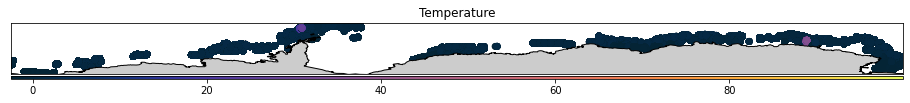

In [211]:
plot_casts('Temperature', nor_data, cmap=cmocean.cm.thermal)

# Assign World Seas Marine Regions to casts

In [9]:
seqs = client.sequences.list(external_id_prefix = 'marine-regions-World_Seas', limit=-1).to_pandas()
seqs.head()

,id,assetId,externalId,metadata,columns,createdTime,lastUpdatedTime
0,94488654153463,5732026414747156,marine-regions-World_Seas_IHO_v3-4276,"{'area': '1326209', 'fileName': 'World_Seas_IH...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599992359939,1599992359939
1,216137642412173,5732026414747156,marine-regions-World_Seas_IHO_v3-4287,"{'area': '2852792', 'fileName': 'World_Seas_IH...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599992380291,1599992380291
2,423540820537983,5732026414747156,marine-regions-World_Seas_IHO_v3-3351,"{'area': '171778', 'fileName': 'World_Seas_IHO...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599992389821,1599992389821
3,508199934052692,5732026414747156,marine-regions-World_Seas_IHO_v3-4262,"{'area': '10438', 'fileName': 'World_Seas_IHO_...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599992391626,1599992391626
4,625356351365624,5732026414747156,marine-regions-World_Seas_IHO_v3-4336,"{'area': '2684', 'fileName': 'World_Seas_IHO_v...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599992393293,1599992393293


In [243]:
seqs = client.sequences.list(external_id_prefix = 'marine-regions-Intersect_EEZ_IHO', limit=-1).to_pandas()
seqs.head()

,id,assetId,externalId,metadata,columns,createdTime,lastUpdatedTime
0,6212518452889,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-26572,"{'fid': '38.0', 'fileName': 'Intersect_EEZ_IHO...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990160189,1599990160189
1,18023206477146,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25419,"{'fid': '320.0', 'fileName': 'Intersect_EEZ_IH...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990284998,1599990284998
2,19747597815281,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25224,"{'fid': '96.0', 'fileName': 'Intersect_EEZ_IHO...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990213824,1599990213824
3,26383366321859,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25413,"{'fid': '477.0', 'fileName': 'Intersect_EEZ_IH...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990328241,1599990328241
4,48306913996100,3272823039995957,marine-regions-Intersect_EEZ_IHO_v4_2020-25720,"{'fid': '191.0', 'fileName': 'Intersect_EEZ_IH...","[{'externalId': 'polygonId', 'valueType': 'LON...",1599990241672,1599990241672


Create dataframe with name of marine region and polygons

In [251]:
df_mr = pd.DataFrame({'marine_regions':[seqs.iloc[i]['metadata']['MARREGION'] for i in range(len(seqs))],
                      'iho_sea':[seqs.iloc[i]['metadata']['IHO_SEA'] for i in range(len(seqs))],
                      'MRGID':[seqs.iloc[i]['metadata']['MRGID'] for i in range(len(seqs))],
                      'poly_count':[int(seqs.iloc[i]['metadata']['polygonCount']) for i in range(len(seqs))],
                      'id':seqs['id']})
get_poly(df_mr)
df_mr = gpd.GeoDataFrame(df_mr)

In [253]:
df_mr.head()

,marine_regions,iho_sea,MRGID,poly_count,id,geometry
0,Bonaire part of the Caribbean Sea,Caribbean Sea,26572,1,6212518452889,"POLYGON ((-68.42272 11.81057, -68.43006 11.859..."
1,Maldives part of the Arabian Sea,Arabian Sea,25419,1,18023206477146,"POLYGON ((73.13438 -0.60213, 73.15146 -0.68815..."
2,Danish part of the Kattegat,Kattegat,25224,1,19747597815281,"POLYGON ((12.61444 55.33172, 12.59852 55.32766..."
3,Somali part of the Arabian Sea,Arabian Sea,25413,1,26383366321859,"POLYGON ((51.89843 11.60131, 51.94430 11.52194..."
4,High Seas of the Laccadive Sea,Laccadive Sea,25720,1,48306913996100,"POLYGON ((77.90413 3.52759, 77.83701 3.46780, ..."


# Join oceanographic data to Marine Regions
Here we find the intersect of points from the casts with the polygons from the marine regions. 
The resulting dataframe will have the associated marine regions for each cast location. 

In [260]:
casts2018_mr = gpd.sjoin(casts2018, df_mr, how="inner", op='intersects')

In [283]:
casts2018_mr.head(2)

,dataset_code,extId,geo_index,date,lon,time,lat,geometry,index_right,marine_regions,iho_sea,MRGID,poly_count,id
cast_wod_3_2018_10026_19274013,gld,cast_wod_3_2018_10026_19274013,10026,20181214,-124.16667,90927.578522,35.89473,POINT (-124.16667 35.89473),197,United States part of the North Pacific Ocean,North Pacific Ocean,25587,1,2932512465604043
cast_wod_3_2018_10026_19274017,gld,cast_wod_3_2018_10026_19274017,10026,20181215,-124.21095,90928.039276,35.86530,POINT (-124.21095 35.86530),197,United States part of the North Pacific Ocean,North Pacific Ocean,25587,1,2932512465604043


In [280]:
def plot_marine_regions_data(df_casts, df_marine_regions, lat=[-90, 90], lon=[-180,180]):
    
    df_casts = df_casts[(df_casts.lat.between(lat[0], lat[1])) & (df_casts.lon.between(lon[0], lon[1]))]

    fig = plt.figure(figsize=(16, 16))
    colors = sns.color_palette('hls', n_colors=len(df_casts.marine_regions.unique()))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    mr = df_casts.marine_regions.unique()
    legend_elements = []
    for i, j in enumerate(mr):
        df_marine_regions[df_marine_regions.marine_regions == j]['geometry'].plot(ax=ax, markersize=5, color=colors[i], zorder=1);
        legend_elements.append(Line2D([0], [0], color = colors[i], lw=4, label=mr[i]))
    

    sns.scatterplot(x="lon", y="lat", data=df_casts, color = 'navy', s=20, marker='o', edgecolor='white', linewidths=0.05)
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]],crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.7, linestyle=':')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.legend(handles=legend_elements, loc='lower center',
               ncol=3, borderaxespad=-12)

    geo_map(ax)

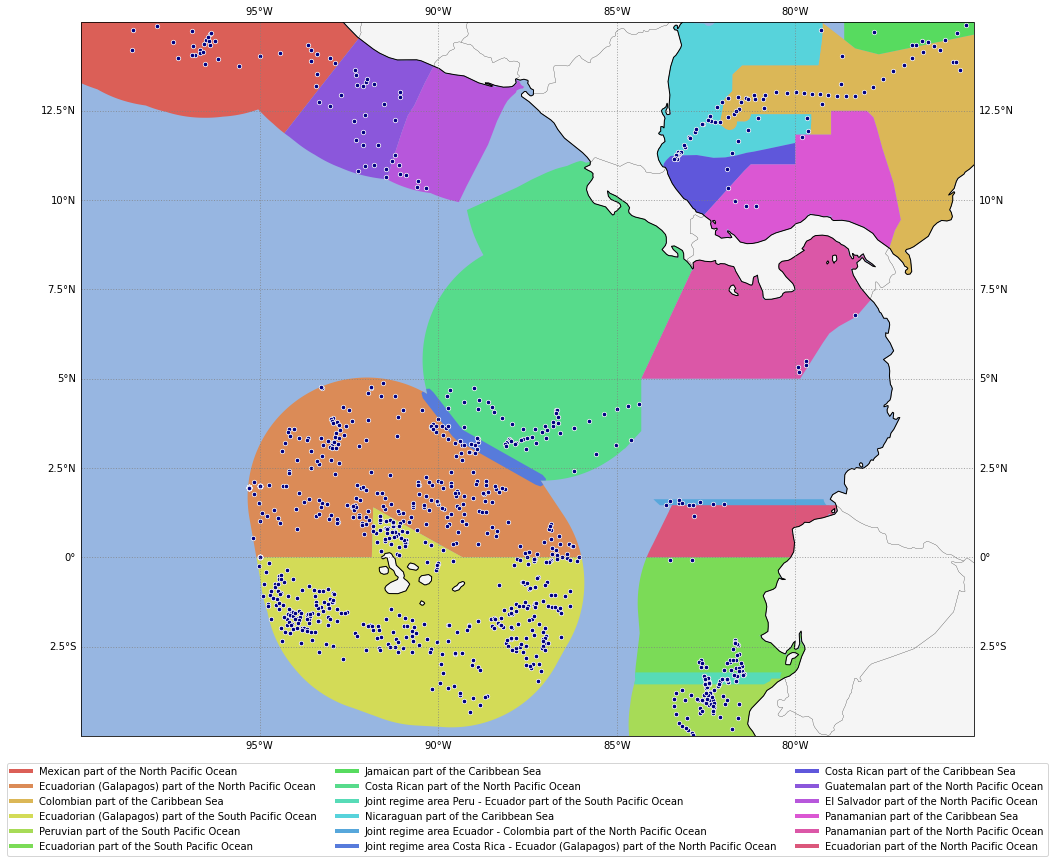

In [282]:
plot_marine_regions_data(casts2018_mr, df_mr, lat=[-5,15], lon=[-100,-75])